In [42]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=3)

In [4]:
# 道路名
# TARGET_ROAD='tateyama'
TARGET_ROAD='kannetsu'

# 交通量
PROCESSED_DATA_DIR = '../Input_processed_data'
TRAFFIC_DIR = f'{PROCESSED_DATA_DIR}/traffic'
TRAFFIC_CSV = f'{TRAFFIC_DIR}/{TARGET_ROAD}_20220621all-merged_filled_1h.csv'

In [5]:
col_types = {
    'start_code': str,
    'end_code': str,
    'road_code': str,
    'jam_type': str,
}

df = pd.read_csv(TRAFFIC_CSV, parse_dates=True, index_col='datetime', dtype=col_types).reset_index()

In [96]:
start_date='2021/5/1'
end_date='2022/5/1'

df_test = df.loc[(df['datetime'] >= pd.Timestamp(start_date)) & (df['datetime'] < pd.Timestamp(end_date))]
df_test.reset_index(drop=True, inplace=True)

In [97]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 551880 entries, 0 to 551879
Data columns (total 51 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   datetime             551880 non-null  datetime64[ns]
 1   index                551880 non-null  int64         
 2   start_name           551880 non-null  object        
 3   end_name             551880 non-null  object        
 4   start_code           551880 non-null  object        
 5   end_code             551880 non-null  object        
 6   start_pref_code      551880 non-null  int64         
 7   end_pref_code        551880 non-null  int64         
 8   start_lat            551880 non-null  float64       
 9   end_lat              551880 non-null  float64       
 10  start_lng            551880 non-null  float64       
 11  end_lng              551880 non-null  float64       
 12  start_degree         551880 non-null  float64       
 13  end_degree    

In [98]:
def linear_interpolate(df, col):
    '''
    dfのcolカラム内の欠損を区間ごとに線形補間する
    '''
    f = lambda g: g.interpolate(method='linear', axis=0)
    
    df.sort_values('datetime', inplace=True)
    df[col] = df.groupby(['start_code', 'end_code'])[col].apply(f)
    return df


def judge_jam(df, road=TARGET_ROAD):
    assert road in {'tateyama', 'kannetsu'}, 'road should be tateyama or kannetsu'
    
    sp = df_test['speed']
    df['jam_flag'] = np.where(sp < 40, 1, 0)
    return df


def preprocess(df):
    # 「年」情報を入れる
    df['year'] = df['datetime'].dt.year
    # 渋滞フラグ 0/1
    df['jam_flag'] = np.where(df['speed'] < 40, 1, 0)
    # 方向を数値化
    direction_map = {'上り': 0, '下り': 1}
    df['direction'] = df['direction'].map(direction_map)
    # 四半期を数値化
    df['quarter'] = df['quarter'].str[-1]
    # object型のカラムを落とす
    drop_cols = ['road_code', 'weather_description', 'jam_type']
    df.drop(drop_cols, axis=1, inplace=True)
    
    # 速度の欠損を埋める
    df = linear_interpolate(df, 'speed')
    
    # 型変換
    type_map = {
        'direction': np.uint8,
        'quarter': np.uint8,
        'jam_quantity': np.uint8,
        'search_1h': int,
        'search_unspec_1d': int,
        'search_unspec_3d': int,
        'search_unspec_7d': int,
        'search_unspec_10d': int,
        'allCars': np.float32,
        'speed': np.float32,
    }
    df = df.astype(type_map)
    
    return df

In [99]:
df_test = preprocess(df_test.copy())
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 551880 entries, 0 to 551879
Data columns (total 50 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   datetime           551880 non-null  datetime64[ns]
 1   index              551880 non-null  int64         
 2   start_name         551880 non-null  object        
 3   end_name           551880 non-null  object        
 4   start_code         551880 non-null  object        
 5   end_code           551880 non-null  object        
 6   start_pref_code    551880 non-null  int64         
 7   end_pref_code      551880 non-null  int64         
 8   start_lat          551880 non-null  float64       
 9   end_lat            551880 non-null  float64       
 10  start_lng          551880 non-null  float64       
 11  end_lng            551880 non-null  float64       
 12  start_degree       551880 non-null  float64       
 13  end_degree         551880 non-null  float64 

In [100]:
key_col = ['datetime', 'start_name', 'end_name']
features = [
    'hour', 'dayofweek', 'is_holiday', 'lane_count', 
    'search_1h', 'search_unspec_1d', 'allCars', 'speed', 'OCC', 'jam_flag'
]
target = 'jam_flag'

In [101]:
# 特徴量を絞る
df_X = df_test.loc[:, key_col + features]
df_y = df_test.loc[:, target]

# データ数
N = df_X.shape[0]
# 時系列長
N_period = df_X.drop_duplicates("datetime").shape[0]
# 区間数
N_sec = df_X.drop_duplicates(["start_name", "end_name"]).shape[0]
# 特徴量数
D = len(features)

# numpy配列を準備
X = np.empty((N_sec, N_period, D), dtype=np.float32)
y = np.empty((N_sec, N_period), dtype=np.float32)

print(X.shape, y.shape)

(63, 8760, 10) (63, 8760)


In [102]:
# 区間別に時系列情報をnumpy配列に格納する
group = df_X.groupby(['start_name', 'end_name'])
for i, (g_key, df_g) in enumerate(group):
    X[i] = df_g.loc[:, features].values
    y[i] = df_g.loc[:, target].values

print(X.shape, y.shape)

(63, 8760, 10) (63, 8760)


In [103]:
# 標準化
# scaler = StandardScaler()
# scaler.fit(X)
# X_norm = X.transform(X)
X_mean = X.reshape(-1, D).mean(axis=0)
X_std = X.reshape(-1, D).std(axis=0)

X_norm = (X - X_mean) / X_std

In [429]:
# 渋滞発生回数が0のものは除く
compress_condition = y.sum(axis=1) > 3

X_norm = X_norm[compress_condition > 0, ...]
y = y[compress_condition > 0, ...]

In [430]:
# train, validに分割
train_ratio = 0.8
ind_split = int(X_norm.shape[1] * train_ratio)
X_train, X_val = X_norm[:, :ind_split], X_norm[:, ind_split:]
y_train, y_val = y[:, :ind_split], y[:, ind_split:]

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(43, 7008, 10) (43, 7008)
(43, 1752, 10) (43, 1752)


In [105]:
# A-B-C-D x 各区間10個ずつ
# batch_size = 2
# time_step = 3

# AB0, AB1, AB2, ..., AB9
# BC0, BC1, BC2, ..., BC9
# CD0, CD1, CD2, ..., CD9

# ABに限定するのであれば
# [AB0, AB1, AB2], [AB1, AB2, AB3], ..., [AB7, AB8, AB9] -> 7個できる

# バッチ数を区間数の倍数にすればいい？
# [[AB0, AB1, AB2]
# [BC0, BC1, BC2]
# [CD0, CD1, CD2]]

# 下みたいに区間に対応するラベルさえしっかり出力できるなら問題ない
# [[AB0, AB1, AB2] -> AB3
# [AB1, AB2, AB3] -> AB4
# [AB5, AB6, AB7] -> AB8
# [BC2, BC3, BC4] -> BC5
# [BC7, BC8, BC9] -> BC10
# [CD0, CD1, CD2]] -> CD3

In [448]:
# LSTM用のtime step, 区間のstackの処理はdatasetに投げる
# dataloaderはミニバッチに区切るだけ
class LSTMData(torch.utils.data.Dataset):
    def __init__(self, data_X, data_y, time_step):
        X, y = self.__sliding_window(data_X, data_y, time_step)       
        self.X = X
        self.y = y
        self.time_step = time_step

        
    def __len__(self):
        return self.X.shape[0]


    def __getitem__(self, index):
        return self.X[index], self.y[index]

    
    def __sliding_window(self, data_X, data_y, time_step):
        N_sections, N_periods, _ = data_X.shape
        X = []
        y = []
        
        for i in range(N_sections):
            # 各区間ごとにtime step分だけ切り出す
            for t in range(time_step, N_periods-24):
                time_pred = t + 24
                time_input = (t - time_step, t + 1)
                x_ = data_X[i, time_input[0] : time_input[1]]
                y_ = data_y[i, time_pred]
                X.append(x_)
                y.append(y_)
        
        X = torch.from_numpy(np.array(X, dtype=np.float32))
        y = torch.from_numpy(np.array(y, dtype=np.int64))
        return X, y

In [432]:
class BalancedLoader:
    def __init__(self, dataset, batch_size, shuffle=False):
        self.features = dataset[:][0]
        self.labels = dataset[:][1]
        assert batch_size % 2 == 0
        self.batch_size = batch_size
        self.n_samples = batch_size // 2
        
        label_counts = np.bincount(self.labels)
        if label_counts.shape[0] != 2:
            raise ValueError(f'Expected 2 class but got {label_counts.shape[0]} class')
        if label_counts.min() < self.n_samples:
            raise ValueError('`n_samples` must be less than minor label data size')
            
        major_label = label_counts.argmax()
        minor_label = label_counts.argmin()
        self.major_indices = np.where(self.labels == major_label)[0]
        self.minor_indices = np.where(self.labels == minor_label)[0]
        
        if shuffle:
            np.random.shuffle(self.major_indices)
            
    def __iter__(self):
        count = 0
        while count + self.n_samples < len(self.major_indices):
            mini_major_indices = self.major_indices[count:count+self.n_samples]
            mini_minor_indices = np.random.choice(self.minor_indices, self.n_samples, replace=False)
            mini_indices = mini_major_indices.tolist() + mini_minor_indices.tolist()
            
            features = self.features[mini_indices]
            labels = self.labels[mini_indices]
            yield features, labels
            
            count += self.n_samples
    
    def __len__(self):
        return len(self.major_indices) // self.n_samples

In [433]:
class Net(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, num_layers, batch_first=True):
        super().__init__()
        
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(in_dim, hid_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hid_dim, out_dim)
    
    def forward(self, x):
        outs, (h, c) = self.lstm(x)
        out = self.fc(h[0])
        return out
    

class DropNet(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, num_layers, dropout=0.2, batch_first=True):
        super().__init__()
        
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        self.num_layers = num_layers
        self.dropout_ratio = dropout
        
        self.lstm = nn.LSTM(in_dim, hid_dim, num_layers, batch_first=True)
        self.dropout1 = nn.Dropout(p=dropout)
        self.fc1 = nn.Linear(hid_dim, hid_dim // 4)
        self.dropout2 = nn.Dropout(p=dropout)
        self.fc2 = nn.Linear(hid_dim // 4, out_dim)
        
        self.dropout = nn.Dropout(p=dropout)
    
    def forward(self, x):
        outs, (h, c) = self.lstm(x)
        out = self.dropout1(h[0])
        out = self.fc1(out)
        out = self.dropout2(out)
        out = self.fc2(out)
        return out

In [434]:
def train(n_epochs, optimizer, model, loss_fn, train_loader, val_loader, file_output=True):
    model.train()
    
    train_losses = []
    val_losses = []
    
    for epoch in range(1, n_epochs + 1):
        train_loss = 0.0
        val_loss = 0.0
        
        for data, target in train_loader:
            data = data.to(device=device)
            target = target.to(device=device)
            target = F.one_hot(target, num_classes=2).float()
            
            out = model(data)
            loss = loss_fn(out, target)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
        with torch.no_grad():
            for data, target in val_loader:
                data = data.to(device=device)
                target = target.to(device=device)
                target = F.one_hot(target, num_classes=2).float()

                out = model(data)
                loss = loss_fn(out, target)

                val_loss += loss.item()
        
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        
        if epoch <= 3 or epoch % 10 == 0:
            log = f'{dt.datetime.now()} | Epoch: {epoch}, Train Loss: {train_loss / len(train_loader)}, Valid Loss: {val_loss / len(val_loader)}'
            print(log)
            
            if file_output:
                with open('./logs_cars.txt', mode='a') as f:
                    f.write(log + '\n')
        
    return train_losses, val_losses
            

def validate(model, train_loader, val_loader):
    model.eval()
    
    loss_dict = {
        'train': [],
        'valid': []
    }
    for name, loader in [('train', train_loader), ('valid', val_loader)]:    
        with torch.no_grad():
            tp, fp, fn, tn = 0, 0, 0, 0
            for data, target in loader:
                data = data.to(device=device)
                target = target.to(device=device)
                
                out = model(data)
                _, predicted = torch.max(out, dim=1)
                tp += ((predicted == 1) & (target == 1)).sum()
                fp += ((predicted == 1) & (target == 0)).sum()
                fn += ((predicted == 0) & (target == 1)).sum()
                tn += ((predicted == 0) & (target == 0)).sum()

            accuracy = (tp + tn) / (tp + fp + fn + tn)
            precision = tp / (tp + fp)
            recall = tp / (tp + fn)
            f1 = 2 * precision * recall / (precision + recall)
               
            print(f'{name} Accuracy: {accuracy:.3f}')
            print(f'{name} Precision: {precision:.3f}')
            print(f'{name} Recall: {recall:.3f}')
            print(f'{name} F1 Score: {f1:.3f}')
    return loss_dict

In [435]:
time_step = 6
batch_size = 256

dataset_train = LSTMData(X_train, y_train, time_step)
dataset_valid = LSTMData(X_val, y_val, time_step)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)

In [446]:
n_epochs = 20
in_dim = D
hid_dim = 64
out_dim = 2
num_layers = 1

model = Net(in_dim, hid_dim, out_dim, num_layers).to(device=device)
optimizer = optim.Adam(model.parameters())

# loss_weights = torch.tensor([1.0, 100.0]).to(device=device)
# loss_fn = nn.BCEWithLogitsLoss(weight=loss_weights)
loss_fn = nn.BCEWithLogitsLoss()

train_losses, val_losses = train(n_epochs, optimizer, model, loss_fn, train_loader, val_loader)

2022-07-30 09:26:54.020494 | Epoch: 1, Train Loss: 0.19972445009400874, Valid Loss: 0.15968470053119055
2022-07-30 09:26:58.242132 | Epoch: 2, Train Loss: 0.09536364662427436, Valid Loss: 0.11597020121543178
2022-07-30 09:27:02.128759 | Epoch: 3, Train Loss: 0.06699817393320144, Valid Loss: 0.09718669384926513
2022-07-30 09:27:29.621375 | Epoch: 10, Train Loss: 0.027218887410693726, Valid Loss: 0.08107169138408488
2022-07-30 09:28:08.784791 | Epoch: 20, Train Loss: 0.015234904639913316, Valid Loss: 0.07918859077280192


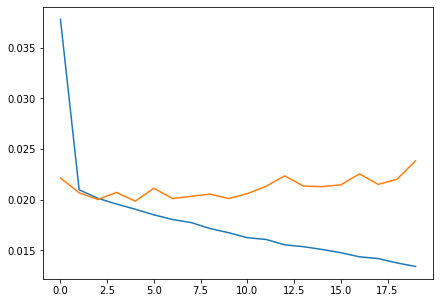

In [438]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(range(len(train_losses)), train_losses)
ax.plot(range(len(val_losses)), val_losses)
# ax.set_yscale('log')
# ax.set_ylim(0, 1e3)
plt.show()

In [439]:
loss_dict = validate(model, train_loader, val_loader)

train Accuracy: 0.996
train Precision: 0.658
train Recall: 0.386
train F1 Score: 0.487
valid Accuracy: 0.995
valid Precision: 0.375
valid Recall: 0.182
valid F1 Score: 0.245


## balanced

In [469]:
class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super(FocalLoss, self).__init__()
        self.gamma = gamma

    def forward(self, outputs, targets): 
        bce_loss = F.binary_cross_entropy_with_logits(outputs, targets)
        logpt = -bce_loss
        pt = torch.exp(logpt)
        focal_loss = -((1 - pt) ** self.gamma) * logpt
        return focal_loss

In [465]:
time_step = 168
batch_size = 512

dataset_train = LSTMData(X_train, y_train, time_step)
dataset_valid = LSTMData(X_val, y_val, time_step)

train_loader = BalancedLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)

In [505]:
n_epochs = 10
in_dim = D
hid_dim = 64
out_dim = 2
num_layers = 2

# model_balanced = DropNet(in_dim, hid_dim, out_dim, num_layers, dropout=0.25).to(device=device)
model_balanced = Net(in_dim, hid_dim, out_dim, num_layers).to(device=device)
optimizer = optim.Adam(model_balanced.parameters())

# weights = torch.tensor([1.0, 100.0]).to(device=device)
# loss_fn = nn.BCEWithLogitsLoss()
loss_fn = FocalLoss(gamma=2.0)

train_losses, val_losses = train(n_epochs, optimizer, model_balanced, loss_fn, train_loader, val_loader)

2022-07-31 16:30:48.370165 | Epoch: 1, Train Loss: 0.012504312157658721, Valid Loss: 0.009757060036192505
2022-07-31 16:30:58.830228 | Epoch: 2, Train Loss: 0.0019814408462274047, Valid Loss: 0.005191574239719209
2022-07-31 16:31:08.663526 | Epoch: 3, Train Loss: 0.0015046565463615494, Valid Loss: 0.004050382316441113
2022-07-31 16:32:19.882769 | Epoch: 10, Train Loss: 0.0001974411388589342, Valid Loss: 0.0024538551413737703


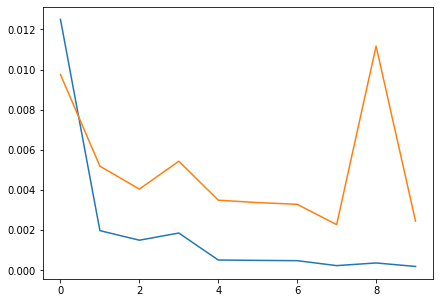

In [508]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(range(len(train_losses)), train_losses)
ax.plot(range(len(val_losses)), val_losses)
# ax.set_yscale('log')
# ax.set_ylim(0, 1e3)
plt.show()

In [509]:
loss_dict = validate(model_balanced, train_loader, val_loader)

train Accuracy: 0.989
train Precision: 0.979
train Recall: 1.000
train F1 Score: 0.990
valid Accuracy: 0.975
valid Precision: 0.084
valid Recall: 0.455
valid F1 Score: 0.142


In [458]:
tmp_train = df_test[(df_test['start_name'] == '鶴ヶ島') & (df_test['direction'] == 1)]
tmp_train = tmp_train.loc[:, key_col + features]

# 時系列長
N_period = tmp_train.drop_duplicates("datetime").shape[0]
# 区間数
N_sec = tmp_train.drop_duplicates(["start_name", "end_name"]).shape[0]
# 特徴量数
D = len(features)

tmp_train_value = tmp_train[features].values.reshape(1, N_period, D)
tmp_train_norm = (tmp_train_value - X_mean) / X_std

TypeError: can only concatenate list (not "Tensor") to list

In [193]:
tmp_X = []

for i in range(N_sec):
    for t in range(time_step, N_period - 24):
        time_pred = t + 24
        time_input = (t - time_step, t + time_step + 1)
        x_ = tmp_train_norm[i, time_input[0] : time_input[1]]
        tmp_X.append(x_)

tmp_X = torch.from_numpy(np.array(tmp_X, dtype=np.float32))

In [136]:
tmp_pred = model(tmp_X.to(device=device))
_, predicted = torch.max(tmp_pred, dim=1)
predicted = predicted.to(device='cpu')

In [137]:
ys = np.arange(time_step, N_period - 24) + 24
tmp_y = tmp_train.iloc[ys, -1].values.reshape(-1, 1)
tmp_y = torch.from_numpy(tmp_y).to(device='cpu')

In [138]:
predicted[:10], tmp_y[:10]

(tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1]),
 tensor([[0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [1],
         [1],
         [0]]))

In [399]:
with torch.no_grad():
    i = 0
    for data, target in dataset_train:
        if i >= 10:
            break
        i += 1
        print(f'------- {i} -------')
        out = model(data.to(device=device))
        print(target)
        print(out)
        print(torch.sqrt(nn.functional.mse_loss(out, target.to(device=device))).item())
        print()

------- 1 -------
tensor(126.)
tensor([115.0645], device='cuda:0')
10.935508728027344

------- 2 -------
tensor(134.)
tensor([134.9498], device='cuda:0')
0.9497833251953125

------- 3 -------
tensor(170.)
tensor([168.9665], device='cuda:0')
1.0334625244140625

------- 4 -------
tensor(198.)
tensor([204.4083], device='cuda:0')
6.4083099365234375

------- 5 -------
tensor(179.)
tensor([184.3132], device='cuda:0')
5.313201904296875

------- 6 -------
tensor(202.)
tensor([209.7910], device='cuda:0')
7.79095458984375

------- 7 -------
tensor(224.)
tensor([240.2662], device='cuda:0')
16.266204833984375

------- 8 -------
tensor(317.)
tensor([303.8457], device='cuda:0')
13.154327392578125

------- 9 -------
tensor(383.)
tensor([374.0816], device='cuda:0')
8.918426513671875

------- 10 -------
tensor(440.)
tensor([439.5305], device='cuda:0')
0.469482421875



/tmp/ipykernel_65/1850680170.py:11: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  print(torch.sqrt(nn.functional.mse_loss(out, target.to(device=device))).item())


In [339]:
n_epochs = 3000
in_dim = X_train.shape[-1]
hid_dim = 100
out_dim = 1
num_layers = 1

model = Net(in_dim, hid_dim, out_dim, num_layers).to(device=device)
optimizer = optim.Adam(model.parameters())

loss_fn = nn.MSELoss()

losses = []

for epoch in range(n_epochs):
    total_loss = 0
    for data, target in train_loader:
        data = data.to(device=device)
        target = target.unsqueeze(1).to(device=device)
        
        out = model(data)
        loss = loss_fn(out, target)
        total_loss += loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    losses.append(total_loss)

    if epoch < 3 or (epoch + 1) % 100 == 0:
        print(f'{dt.datetime.now()} | Epoch {epoch+1} | Loss: {loss}')

2022-07-21 17:24:34.155558 | Epoch 1 | Loss: 65953.34375
2022-07-21 17:24:40.475783 | Epoch 2 | Loss: 6871.1943359375
2022-07-21 17:24:46.874386 | Epoch 3 | Loss: 11021.1640625


KeyboardInterrupt: 